# Reduction and calibration script for long-slit spectra

In [1]:
__main__ = 'Manual_reduction_spectra'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '0.2'
__keywords__ = ['astronomy', 'spectroscopy', 'astropy', 'specutils', 'specreduce', 'matplotlib']
#import sys, numpy, matplotlib
#print('Python ' + sys.version)
#print('matplotlib ' + str(sys.modules['matplotlib'].__version__))
#print('numpy ' + str(sys.modules['numpy'].__version__))
#!jupyter --version


## Configuration

In [18]:
#dir = 'e:/Astro/Captures/20231008_Void/'
dir = '../../../CAPTURES/2023_RENNES_L3_TP/'
#dir = 'E:/Astro/Captures/20161006_tp_spectro_L3/'

# CALC
obs_latitude = 47.89
obs_longitude = -1.50

#bias = 'Bias'
bias = 'offset-*'
#darks = 'dark-*'
darks = 'noir-600-*'
flats = 'flat-*'
calibs = 'neon-*'
#sciences = 'agdra-*'
#target = 'agdra'
sciences = 'agdra-*'
target = 'agdra'

#sciences = 'hd158460-*'
#target = 'hd158460'

#sciences = 'ngc6543'
#sciences = 'deneb'

trim_region = '600, 600, 2700, 1400'              # x1, y1, x2, y2 
#trim_region = None

masterbias = 'masterbias.fit'
masterdark = 'masterdark.fit'
masterflat = 'masterflat.fit'
mastercalib = 'mastercalib.fit'
masterresponse = 'response.fit'

memory_limit = 1e9               # how much memory (bytes) to allocate to combine operations ?

#camera_electronic_gain = 1.2     # asi 183mm
#camera_readout_noise = 2.2       # asi 183mm

#camera_electronic_gain = 0.13    # atik 420m 
#camera_readout_noise = 3.0       # atik 420m

camera_electronic_gain = 0.27    # atik 460m 
camera_readout_noise = 5.0       # atik 460m

## Imports libs

In [11]:
%matplotlib widget
import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

from ccdproc import Combiner, combine, subtract_bias, subtract_dark, flat_correct
from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from align_combine import align_and_combine

warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', UserWarning)


## Create logger

In [12]:
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')

## Create masters

### Bias

In [14]:
### create masterbias

bias_list =  []
if os.path.exists(dir + masterbias):
    logger.info(masterbias + ' exists already - not (re)created')
else:
    ### prepare filenames lists
    bias_files = [dir + f for f in fnmatch.filter(os.listdir(dir), bias)]
    logger.info('bias files to combine: ' + repr(bias_files))
    for bias_file in bias_files:
        logger.info('bias trim {} ...'.format(bias_file))
        _bias_data = CCDData.read(bias_file, unit = u.adu)
        _bias_trim = _bias_data
        if trim_region is not None:
            _bias_trim = trim_image(_bias_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 

        bias_trim = CCDData(_bias_trim.data.astype('float32'), unit = u.adu , header = _bias_data.header)            
        bias_list.append(bias_trim)
        _bias_data = None

    logger.info('masterbias combine...')
    #_bias_master = combine(bias_list, method = 'median', dtype = np.float32, mem_limit = memory_limit)   
    _bias_master = combine(bias_list,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype = np.float32,
                             mem_limit = memory_limit
                            )

    bias_master = CCDData(_bias_master.data.astype('float32'), unit = u.adu , header = _bias_master.header)    
    bias_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    bias_master.meta['combined'] = True
    bias_master.meta['history'] = 'combined from {} bias file(s)'.format(len(bias_files))
    bias_master.write(dir + masterbias, overwrite=True)
    logger.info('masterbias created - combined from {} bias file(s)'.format(len(bias_files)))
    bias_list = None
    _bias_master = None


2024-04-23 20:22:07 [INFO] - bias files to combine: ['../../../CAPTURES/2023_RENNES_L3_TP/offset-1.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-2.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-3.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-4.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-5.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-6.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-7.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-8.fit', '../../../CAPTURES/2023_RENNES_L3_TP/offset-9.fit']
2024-04-23 20:22:07 [INFO] - bias trim ../../../CAPTURES/2023_RENNES_L3_TP/offset-1.fit ...
2024-04-23 20:22:07 [INFO] - bias trim ../../../CAPTURES/2023_RENNES_L3_TP/offset-2.fit ...
2024-04-23 20:22:07 [INFO] - bias trim ../../../CAPTURES/2023_RENNES_L3_TP/offset-3.fit ...
2024-04-23 20:22:07 [INFO] - bias trim ../../../CAPTURES/2023_RENNES_L3_TP/offset-4.fit ...
2024-04-23 20:22:07 [INFO] - bias trim ../../../CAPTURES/2023_RENNES_L3_TP/offset-5.fit ...
2024-04-23 20:22:07

### Darks

In [15]:
### create masterdark

darks_list = []
if os.path.exists(dir + masterdark):
    logger.info(masterdark + ' exists already - not (re)created')
else:
    ### prepare filenames lists
    dark_files = [dir + f for f in fnmatch.filter(os.listdir(dir), darks)]
    logger.info('dark files to combine : ' + repr(dark_files))

    for dark_file in dark_files:
        _dark_data = CCDData.read(dark_file, unit = u.adu )
        _dark_trim = _dark_data
        if trim_region is not None:
            logger.info('dark trim {} ...'.format(dark_file))
            _dark_trim = trim_image(_dark_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 

        logger.info('masterbias sub {} ...'.format(dark_file))
        _dark_sub = subtract_bias(_dark_trim, bias_master)
        dark_sub = CCDData(_dark_sub.data.astype('float32'), unit = u.adu , header = _dark_data.header)
        darks_list.append(dark_sub)
        _dark_data = None
        _dark_sub = None
        _dark_trim = None
    
    logger.info('masterdark combine...')
    #dark_master = combine(darks_list, method='median', dtype=np.uint32, mem_limit = memory_limit)
    _dark_master = combine(darks_list,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype=np.float32,
                                 mem_limit=memory_limit
                                )
    
    dark_master = CCDData(_dark_master.data.astype('float32'), unit = u.adu , header = _dark_master.header)
    dark_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    dark_master.meta['combined'] = True
    dark_master.meta['history'] = 'masterbias sub + combined from {} dark file(s)'.format(len(dark_files))
    dark_master.write(dir + masterdark, overwrite=True)
    logger.info('masterdark created - bias substracted + combined from {} dark file(s)'.format(len(dark_files)))
    darks_list = None
    _dark_master = None


2024-04-23 20:22:27 [INFO] - dark files to combine : ['../../../CAPTURES/2023_RENNES_L3_TP/noir-600-1.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-2.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-3.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-4.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-5.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-6.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-7.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-8.fit', '../../../CAPTURES/2023_RENNES_L3_TP/noir-600-9.fit']
2024-04-23 20:22:27 [INFO] - dark trim ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-1.fit ...
2024-04-23 20:22:27 [INFO] - masterbias sub ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-1.fit ...
2024-04-23 20:22:27 [INFO] - dark trim ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-2.fit ...
2024-04-23 20:22:28 [INFO] - masterbias sub ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-2.fit ...
2024-04-23 20:22:28 [INFO] - dark trim ../../../CAPTURES/2023_RENNES_L3_TP

### Flats

In [16]:
### create masterflat

flats_list = []
if os.path.exists(dir + masterflat):
    logger.info(masterflat + ' exists already - not (re)created')
else:
    ### prepare filenames lists
    flat_files = [dir + f for f in fnmatch.filter(os.listdir(dir), flats)]
    logger.info('flat files to combine: ' + repr(flat_files))

    for flat_file in flat_files:
        _flat_data = CCDData.read(flat_file, unit = u.adu )
        _flat_trim = _flat_data
        if trim_region is not None:
            logger.info('flat trim {} ...'.format(flat_file))
            _flat_trim = trim_image(_flat_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 

        logger.info('masterbias sub {} ...'.format(flat_file))
        _flat_sub = subtract_bias(_flat_trim, bias_master)
        flat_sub = CCDData(_flat_sub.data.astype('float32'), unit = u.adu , header = _flat_data.header)
        flats_list.append(flat_sub)
        _flat_data = None
        _flat_sub = None
        _flat_trim = None
    
    logger.info('masterflat combine...')
    _flat_master = combine(flats_list, method='sum', dtype=np.float32, mem_limit = memory_limit)
    #_flat_master = combine(flats_list,
     #                            method='average', #scale=inv_median,
      #                           sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
       #                          sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype=np.float32,
        #                         mem_limit=memory_limit
         #                       )
    flat_master = CCDData(_flat_master.data.astype('float32'), unit = u.adu , header = _flat_master.header)
    flat_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    flat_master.meta['combined'] = True
    flat_master.meta['history'] = 'bias substracted + combined from {} flat file(s)'.format(len(flat_files))
    flat_master.write(dir + masterflat, overwrite=True)
    logger.info('masterflat created : bias substracted + combined from {} flat file(s)'.format(len(flat_files)))
    flats_list = None
    _flat_master = None


2024-04-23 20:22:33 [INFO] - flat files to combine: ['../../../CAPTURES/2023_RENNES_L3_TP/flat-1.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-10.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-11.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-12.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-13.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-14.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-15.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-16.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-17.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-2.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-3.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-4.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-5.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-6.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-7.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-8.fit', '../../../CAPTURES/2023_RENNES_L3_TP/flat-9.fit']
2024-04-23 20:22:33 [INFO] - flat trim ../../../CAPTURES/2023_RENNES_L3_TP/flat-1.fit ...

### Calibration

In [19]:
### create mastercalib

calibs_list = [] 
if os.path.exists(dir + mastercalib):
    logger.info(mastercalib + ' exists already - not (re)created')
else:
    calib_files = [dir + f for f in fnmatch.filter(os.listdir(dir), calibs)]
    logger.info('calibration files to combine: ' + repr(calib_files))

    for calib_file in calib_files:
        _calib_data = CCDData.read(calib_file, unit = u.adu )
        _calib_trim = _calib_data
        if trim_region is not None:
            logger.info('calib trim {} ...'.format(calib_file))
            _calib_trim = trim_image(_calib_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 
        
        logger.info('masterbias sub {} ...'.format(calib_file))
        _calib_sub = subtract_bias(_calib_trim, bias_master)
        calib_sub = CCDData(_calib_sub.data.astype('float32'), unit = u.adu , header = _calib_data.header)
        calibs_list.append(calib_sub)
        _calib_data = None
        _calib_sub = None
    
    logger.info('mastercalib combine...')
    #calib_master = combine(calib_list, method='median', dtype=np.float32, mem_limit = memory_limit)
    _calib_master = combine(calibs_list,
                                 method='average', 
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, dtype=np.float32,
                                 mem_limit=memory_limit
                                )
    calib_master = CCDData(_calib_master.data.astype('float32'), unit = u.adu , header = _calib_master.header)
    calib_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    calib_master.meta['combined'] = True
    calib_master.meta['history'] = 'bias substracted + combined from {} calib file(s)'.format(len(calib_files))
    calib_master.write(dir + mastercalib, overwrite=True)
    logger.info('mastercalib created : bias substracted + combined from {} calib file(s)'.format(len(calib_files)))
    calib_list = None
    _calib_master = None


2024-04-23 20:23:25 [INFO] - calibration files to combine: ['../../../CAPTURES/2023_RENNES_L3_TP/neon-1.fit', '../../../CAPTURES/2023_RENNES_L3_TP/neon-2.fit', '../../../CAPTURES/2023_RENNES_L3_TP/neon-3.fit', '../../../CAPTURES/2023_RENNES_L3_TP/neon-4.fit']
2024-04-23 20:23:25 [INFO] - calib trim ../../../CAPTURES/2023_RENNES_L3_TP/neon-1.fit ...
2024-04-23 20:23:25 [INFO] - masterbias sub ../../../CAPTURES/2023_RENNES_L3_TP/neon-1.fit ...
2024-04-23 20:23:26 [INFO] - calib trim ../../../CAPTURES/2023_RENNES_L3_TP/neon-2.fit ...
2024-04-23 20:23:26 [INFO] - masterbias sub ../../../CAPTURES/2023_RENNES_L3_TP/neon-2.fit ...
2024-04-23 20:23:26 [INFO] - calib trim ../../../CAPTURES/2023_RENNES_L3_TP/neon-3.fit ...
2024-04-23 20:23:26 [INFO] - masterbias sub ../../../CAPTURES/2023_RENNES_L3_TP/neon-3.fit ...
2024-04-23 20:23:26 [INFO] - calib trim ../../../CAPTURES/2023_RENNES_L3_TP/neon-4.fit ...
2024-04-23 20:23:26 [INFO] - masterbias sub ../../../CAPTURES/2023_RENNES_L3_TP/neon-4.fit 

## Process science files

### Reduce

In [20]:
### prepare filenames lists
science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), sciences)]
logger.info('science files : ' + repr(science_files))

bias_master = CCDData.read(dir + masterbias, unit = u.adu )
dark_master = CCDData.read(dir + masterdark, unit = u.adu )
flat_master = CCDData.read(dir + masterflat, unit = u.adu )

"""
### process science files - individual science file process version
for sci_file in science_files:
    logger.info('masterbias sub {} ...'.format(sci_file))
    #sci_data = CCDData.read(sci_file, unit = u.adu )
    sci_sub_bias = subtract_bias(CCDData.read(sci_file, unit = u.adu ), bias_master)
    #sci_data = None
    logger.info('masterdark sub {} ...'.format(sci_file))
    sci_sub_dark = subtract_dark(sci_sub_bias, dark_master, scale = True, exposure_time='EXPTIME', exposure_unit=u.second)
    sci_sub_bias = None
    logger.info('masterflat divide {} ...'.format(sci_file))
    sci_div_flat = flat_correct(sci_sub_dark, flat_master)
    sci_sub_dark = None
    sci_ok = CCDData(sci_div_flat.data.astype('float32'), unit = u.adu , header = sci_div_flat.header)
    sci_div_flat = None
    logger.info('writing science file (-ppr) {}'.format(sci_file))
    sci_ok.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    sci_ok.meta['history'] = 'bias substracted + dark substrated + flat divide'
    sci_ok.write(Path(sci_file).with_stem(f"{'ppr'}-{Path(sci_file).stem}"), overwrite=True)
"""

### process science files - ccd_process version
for sci_file in science_files:
    sci_data = CCDData.read(sci_file, unit = u.adu )
    _sci_trim = sci_data
    if trim_region is not None:
        logger.info('science trim {} ...'.format(sci_file))
        _sci_trim = trim_image(sci_data[eval(trim_region)[1]:eval(trim_region)[3], eval(trim_region)[0]:eval(trim_region)[2]]) 
    
    logger.info('processing (masterbias sub + masterdark sub + masterflat divide) {} ...'.format(sci_file))
    sci_data_processed = ccd_process(_sci_trim, 
            oscan = None, 
            gain_corrected = False, 
            trim = None, 
            error = False,
            gain = camera_electronic_gain*u.electron/u.adu ,
            readnoise = camera_readout_noise*u.electron,
            master_bias = bias_master,
            dark_frame = dark_master,
            master_flat = flat_master,
            exposure_key = 'EXPTIME',
            exposure_unit = u.second,
            dark_scale = True)
    sci_ok = CCDData(sci_data_processed.data.astype('float32'), unit = u.adu , header = sci_data.header)
    sci_data = None
    logger.info('writing science datafile (-ppr) {}'.format(sci_file))
    sci_ok.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    sci_ok.meta['history'] = 'bias substracted + dark substrated + flat divide'
    sci_ok.write(Path(sci_file).with_stem(f"{'ppr'}-{Path(sci_file).stem}"), overwrite=True)


2024-04-23 20:23:31 [INFO] - science files : ['../../../CAPTURES/2023_RENNES_L3_TP/agdra-1.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-2.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-3.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-4.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-5.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-6.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-7.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-8.fit', '../../../CAPTURES/2023_RENNES_L3_TP/agdra-9.fit']
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-04-23 20:23:31 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-04-23 20:23:31 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu pa

### Align and combine

In [21]:
#bias_master = CCDData.read(dir + masterbias, unit = u.adu )
#dark_master = CCDData.read(dir + masterdark, unit = u.adu )
#flat_master = CCDData.read(dir + masterflat, unit = u.adu )

### align images and combine using a SUM
science_files_ppr  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'ppr-' + sciences)]
logger.info('science files aligning and combining ... : ' + repr(science_files_ppr))
sci_aligned = align_and_combine(science_files_ppr, np.sum)
sci_master = CCDData(sci_aligned, unit = u.adu , header = sci_ok.header)
sci_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
sci_master.meta['combined'] = True
sci_master.meta['history'] = 'aligned + combined from {} sciences file(s)'.format(len(science_files))
sci_master.write(dir + '2D-' + target + '.fit', overwrite=True)
logger.info('aligned + combined from {} sciences file(s)'.format(len(science_files)))


2024-04-23 20:23:39 [INFO] - science files aligning and combining ... : ['../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-1.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-2.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-3.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-4.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-5.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-6.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-7.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-8.fit', '../../../CAPTURES/2023_RENNES_L3_TP/ppr-agdra-9.fit']
2024-04-23 20:23:39 [INFO] - fftconvolve running...
2024-04-23 20:23:41 [INFO] - images deltas = [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
2024-04-23 20:23:41 [INFO] - images alignement running...
2024-04-23 20:23:41 [INFO] - <function sum at 0x000001A3BCF685B0> Combine operation running...
2024-04-23 20:23:41 [INFO] - aligned + combined from 9 sciences file(s)


### Remove cosmic rays

In [22]:
#bias_master = CCDData.read(dir + masterbias, unit = u.adu )
#dark_master = CCDData.read(dir + masterdark, unit = u.adu )
#flat_master = CCDData.read(dir + masterflat, unit = u.adu )
#sci_master = CCDData.read(dir + '2D-' + target + '.fit', unit = u.adu )

### remove cosmic
logger.info('removing cosmic rays...')
sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
#sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=5, rbox=5, gbox=5, error_image = None)
sci_cleaned.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
sci_cleaned.meta['history'] = 'cosmicray median removed'
sci_cleaned.write(dir + 'final-2D-' + target + '.fit', overwrite=True)
logger.info('final-2D-' + target + '.fit' + ' created')


2024-04-23 20:23:45 [INFO] - removing cosmic rays...
2024-04-23 20:23:46 [INFO] - final-2D-agdra.fit created


### Display

2024-04-23 20:23:48 [INFO] - summary : displaying all spectra...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-04-23 20:23:48 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-04-23 20:23:48 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-04-23 20:23:48 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-04-23 20:23:48 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.

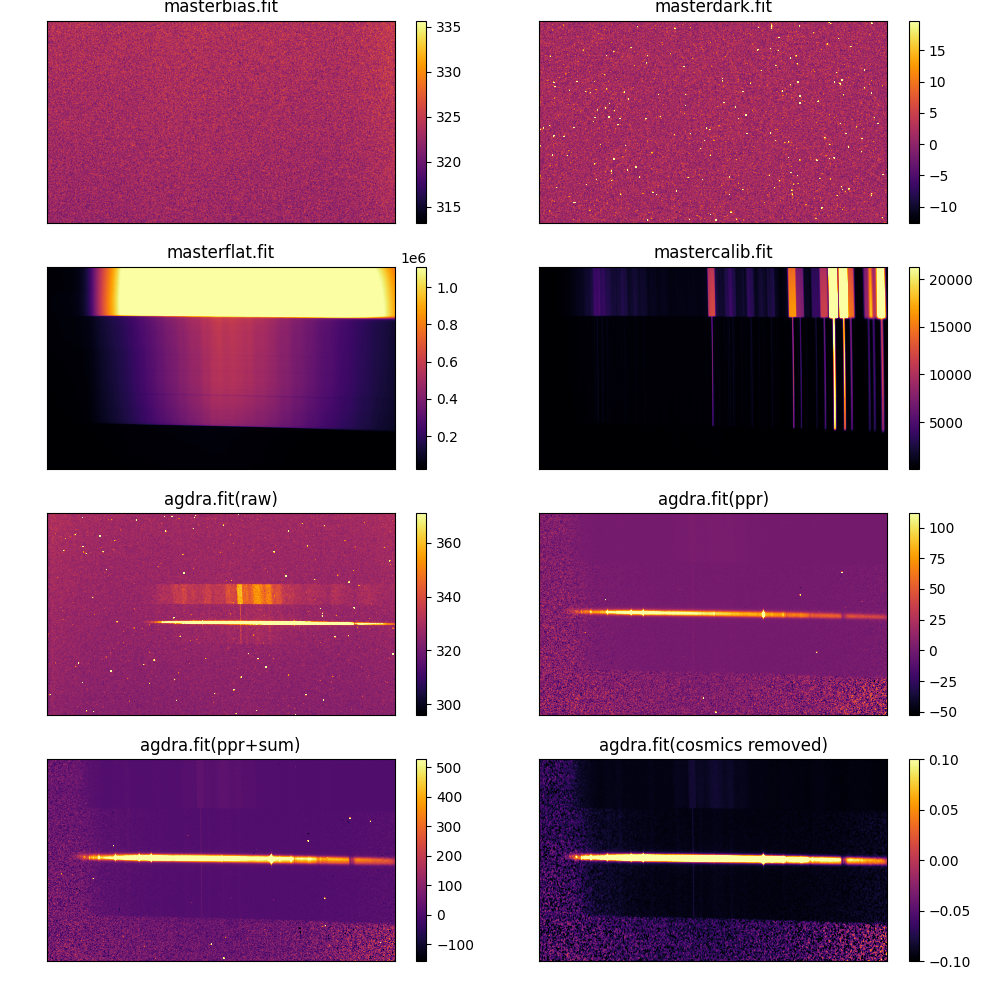

In [23]:
logger.info('summary : displaying all spectra...')

master_bias = CCDData.read(dir + masterbias, unit = u.adu)
master_dark = CCDData.read(dir + masterdark, unit = u.adu)
master_flat = CCDData.read(dir + masterflat, unit = u.adu)
science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), sciences)]
ppr_science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'ppr-' + sciences)]
one_science = CCDData.read(science_files[0], unit = u.adu)
one_science_ppr = CCDData.read(ppr_science_files[0], unit = u.adu)
master_science = CCDData.read(dir + '2D-' + target + '.fit', unit = u.adu)
master_science_cosmic = CCDData.read(dir + 'final-2D-' + target + '.fit', unit = u.adu)
master_calib = CCDData.read(dir + mastercalib, unit = u.adu)

### prepare canvas for 4x2 images 
colormap = plt.cm.inferno
cuts = (5, 98.0)
#fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(12, 12))
#plt.subplots_adjust(wspace=0.1,hspace=0.1,left=0.1,top=0.9,right=0.9,bottom=0.1)
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
plt.tight_layout()
fig.canvas.toolbar_position = 'right'

### display images set
imgs_to_display = [master_bias, master_dark, master_flat, master_calib,
                   one_science, one_science_ppr, master_science, master_science_cosmic]
name_to_display = [masterbias, masterdark, masterflat, mastercalib, 
                   target + '.fit' + '(raw)', target + '.fit' + '(ppr)', target + '.fit' + '(ppr+sum)', target + '.fit' + '(cosmics removed)']
for i, img, name in zip(range(len(imgs_to_display)), imgs_to_display, name_to_display):
    im = ax[int(i/2), int(i%2)].imshow(img, origin='lower', aspect='auto', cmap=colormap)
    cb = plt.colorbar(im)
    ax[int(i/2), int(i%2)].xaxis.set_visible(False)
    ax[int(i/2), int(i%2)].yaxis.set_visible(False)
    ax[int(i/2), int(i%2)].set_title(name)
    im.set_clim(np.percentile(img, cuts))

im_ = plt.imshow(master_science_cosmic.data , origin='lower', aspect='auto', cmap=colormap)
im_.set_clim(np.percentile(master_science_cosmic.data, cuts))


## Create spectra 

### Extract science spectra

In [13]:
### run if spectra free of cosmics is to be used 
#master_science = sci_cleaned.data

2024-03-05 22:44:11 [INFO] - extracting science spectra...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-03-05 22:44:11 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-03-05 22:44:11 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-03-05 22:44:11 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Text(87.72222222222221, 0.5, 'ADU')

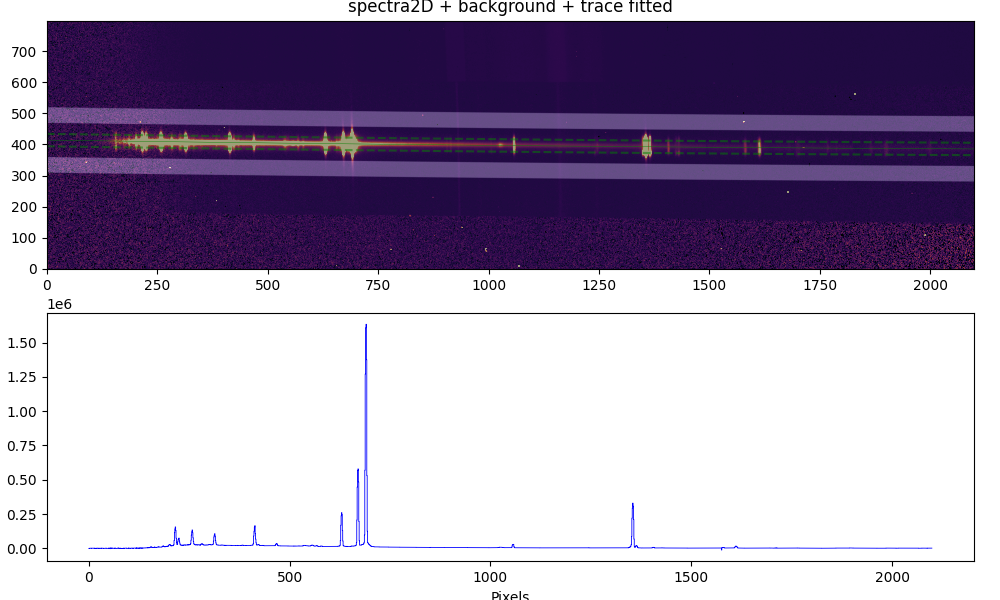

In [14]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting science spectra...')

master_science = CCDData.read(dir + '2D-' + target + '.fit', unit = u.adu)
master_science_cosmic = CCDData.read(dir + 'final-2D-' + target + '.fit', unit = u.adu)
master_calib = CCDData.read(dir + mastercalib, unit = u.adu)

#sci_tr = tracing.FlatTrace(master_science, 407)
sci_tr = tracing.FitTrace(master_science,  bins = 64, trace_model=models.Polynomial1D(degree=2), peak_method = 'gaussian', window = 50, guess=407)
#trace_model : one of Chebyshev1D, Legendre1D, Polynomial1D, or Spline1D
#peak_method : One of gaussian, centroid, or max. gaussian
bg = background.Background.two_sided(master_science, sci_tr, separation=80, width=50) 
extract = extract.BoxcarExtract(master_science - bg, sci_tr, width = 20)
sci_spectrum = extract()

cuts = (5, 99.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
plt.tight_layout()

im = ax0.imshow(master_science, origin='lower', aspect='auto', cmap=plt.cm.magma)
ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.3)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.set_title('spectra2D + background + trace fitted')

ax1.step(sci_spectrum.spectral_axis , sci_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')


### Extract calibration spectra

2024-03-05 22:44:17 [INFO] - extracting neon spectrum...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-03-05 22:44:17 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


(0.0, 100000.0)

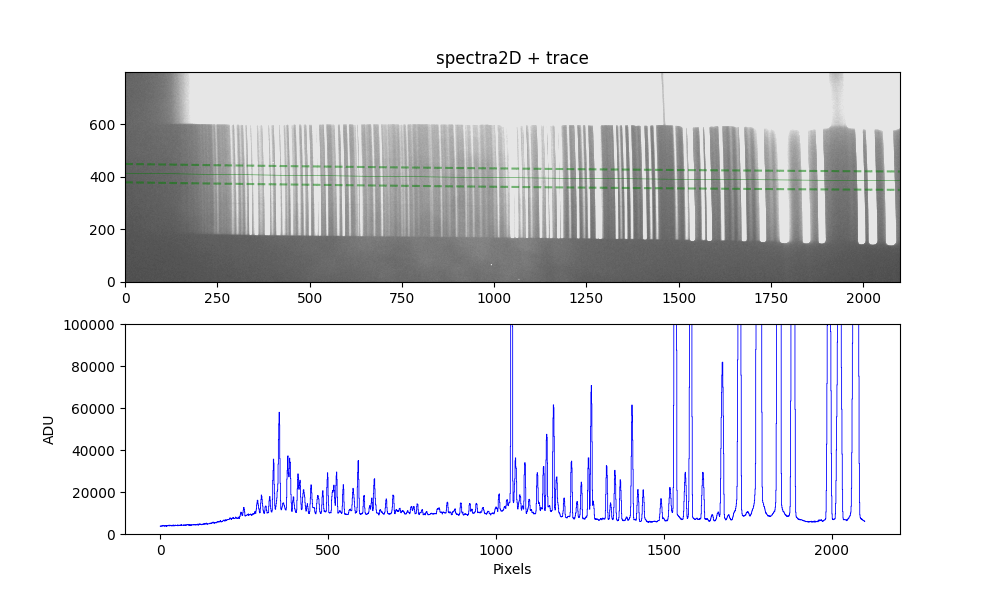

In [15]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting neon spectrum...')

neon_data = CCDData.read(dir + mastercalib, unit = u.adu)

#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
#neon_tr = tracing.FlatTrace(neon_data,sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#neon_tr = tracing.ArrayTrace(neon_data, sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(neon_data, sci_tr, separation=50, width=0) 
extract = extract.BoxcarExtract(neon_data , sci_tr, width = 35)
neon_spectrum = extract()

cuts = (5, 98.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
#plt.tight_layout()

im = ax0.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
#ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)

ax0.set_title('spectra2D + trace')

ax1.step(neon_spectrum.spectral_axis , neon_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')
ax1.set_ylim(0, 0.1e6)


### Calibrate spectra

2024-03-05 22:44:18 [INFO] - calibrating neon spectrum...
residuals : [-0.08423438  0.30668548 -0.21810065  0.66102757 -0.27359542 -0.62485782
 -0.18690869  0.41998391] Angstrom
fitted  Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                c1                  c2          
         Angstrom       Angstrom / pix     Angstrom / pix2    
    ----------------- ----------------- ----------------------
    3313.326773831569 2.535947975202574 -0.0001018374976719846


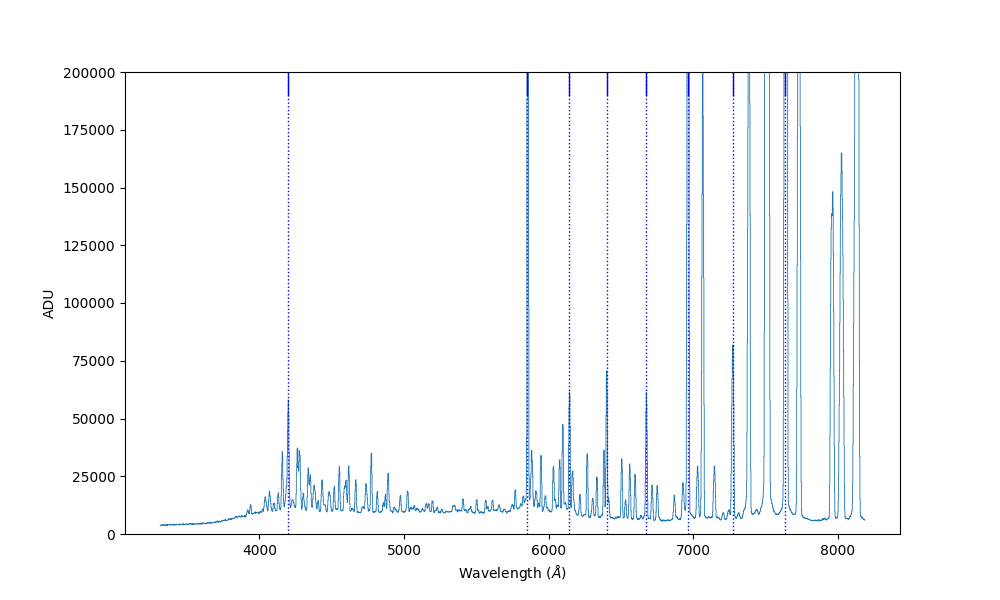

In [16]:
import astropy.units as u
from astropy.modeling import models, fitting
from specreduce import WavelengthCalibration1D

logger.info('calibrating neon spectrum...')

### alpy-600
#pixels = [351, 589, 1045, 1403, 1885, 2073]*u.pix
#wavelength = [4200.67, 4764.87, 5852.49, 6677.28, 7272.94, 7635.11]*u.AA
pixels =     [355,     1045,    1171     , 1284,   1406,      1535  , 1674  , 1840 ]*u.pix
wavelength = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]*u.AA
#wavelength_ = wavelength #= [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]

### StarEx-2400
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

### DADOS-200
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

#line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
#input_spectrum, matched_line_list=None, line_pixels=None, line_wavelengths=None, catalog=None, input_model=Linear1D(), fitter=None
cal = WavelengthCalibration1D(input_spectrum = neon_spectrum,
      #matched_line_list = line_list,
      line_wavelengths = wavelength,
      line_pixels = pixels,
      input_model = models.Polynomial1D(degree = 2),
      #fitter = fitting.LMLSQFitter()
     )
print('residuals :', cal.residuals )
print('fitted ', cal.fitted_model )

neon_calibrated_spectrum = cal.apply_to_spectrum(neon_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux, linewidth = '0.6')  
for line in wavelength:
    plt.axvline(line.value, 0.95, 1.0, color = 'b', lw = 1.0)
    plt.axvline(line.value, color = 'b', lw = 1.0, linestyle = ':')
plt.ylim(0, 0.2e6);


### Apply to science spectra

2024-03-05 22:44:19 [INFO] - calibrating science spectra...


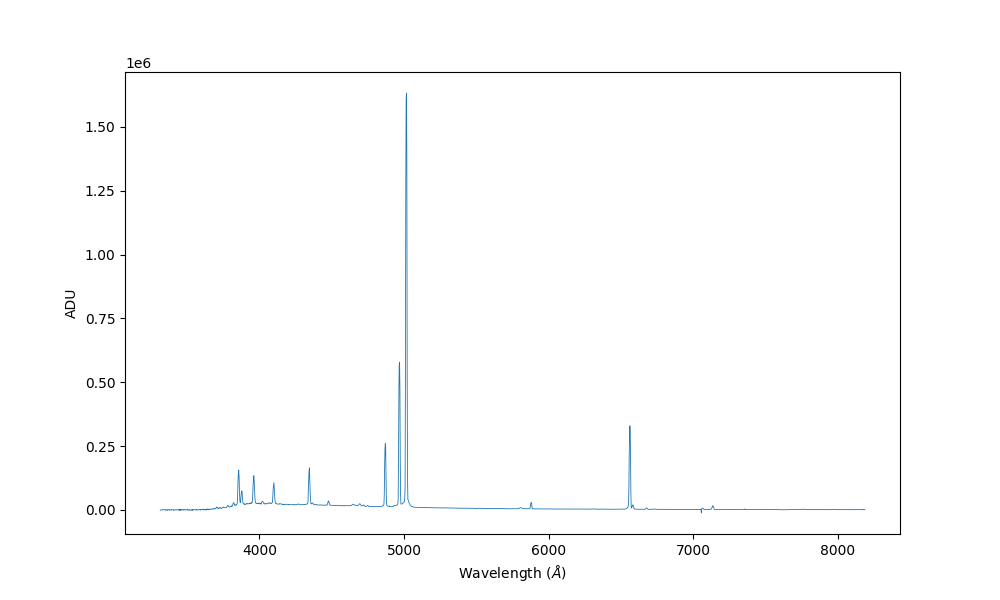

In [17]:
logger.info('calibrating science spectra...')
sci_calibrated_spectrum = cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux, linewidth = '0.6');


### Correct instrument response & airmass

In [18]:
from astropy.coordinates import get_sun, AltAz, EarthLocation
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy.time import Time

### compute zenith distance (if not present in fit header)
target_coord = SkyCoord.from_name(target)
target_time = Time(master_science.header['DATE-OBS'])
obs_coord = EarthLocation(lon = obs_longitude * u.deg, lat = obs_latitude * u.deg)
altaz = AltAz(obstime=target_time, location = obs_coord)

ZD = target_coord.transform_to(AltAz(obstime = target_time, location = obs_coord)).zen
airmass = 1.0 / np.cos(ZD)
logger.info(f'computed ZD={ZD}, airmass={airmass}')


2024-03-05 22:44:21 [INFO] - computed ZD=35.333499931391096 deg, airmass=1.2257912563706919


2024-03-05 22:44:21 [INFO] - reusing existing response file ... : response.fit


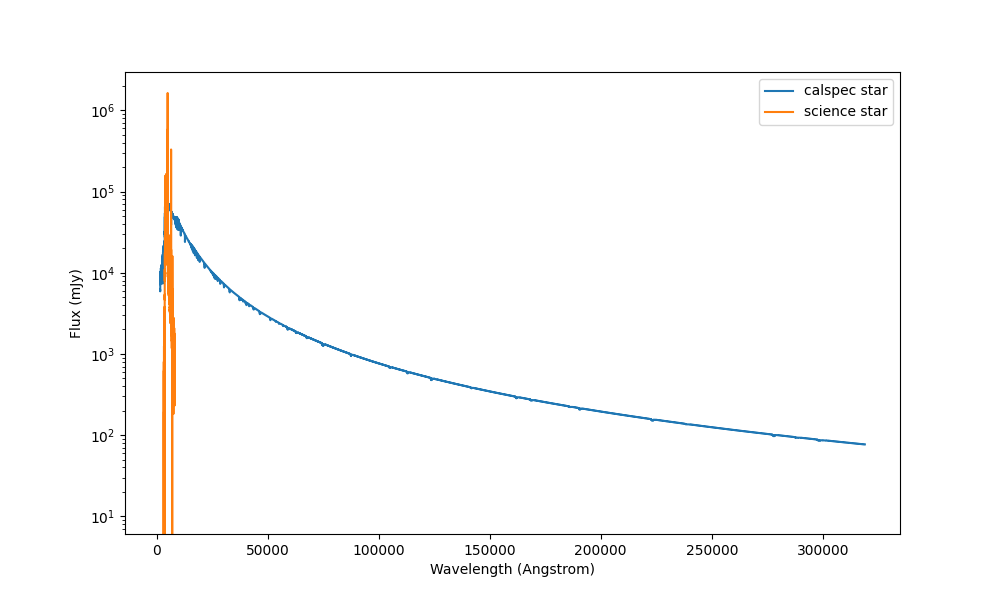

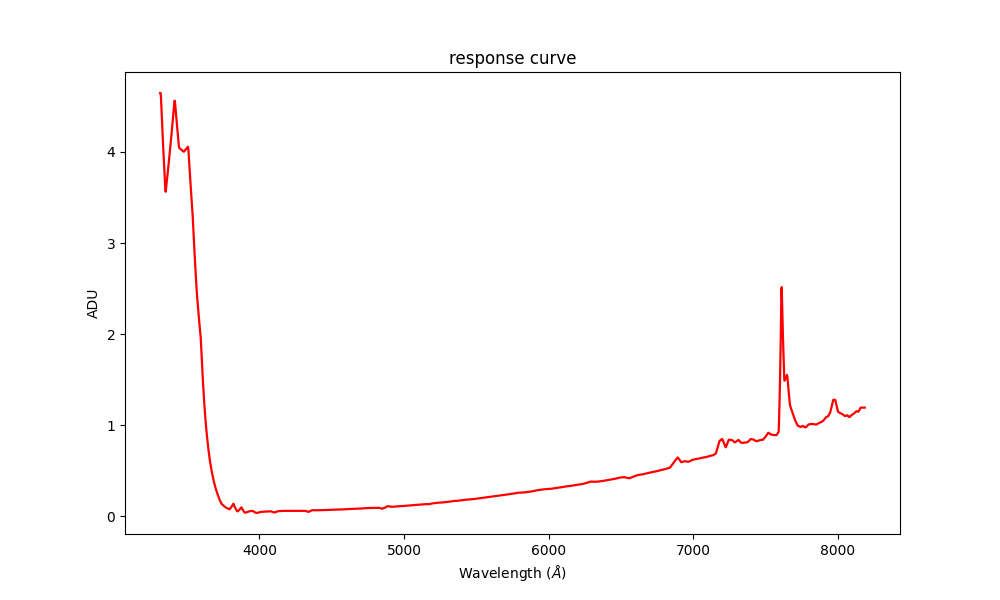

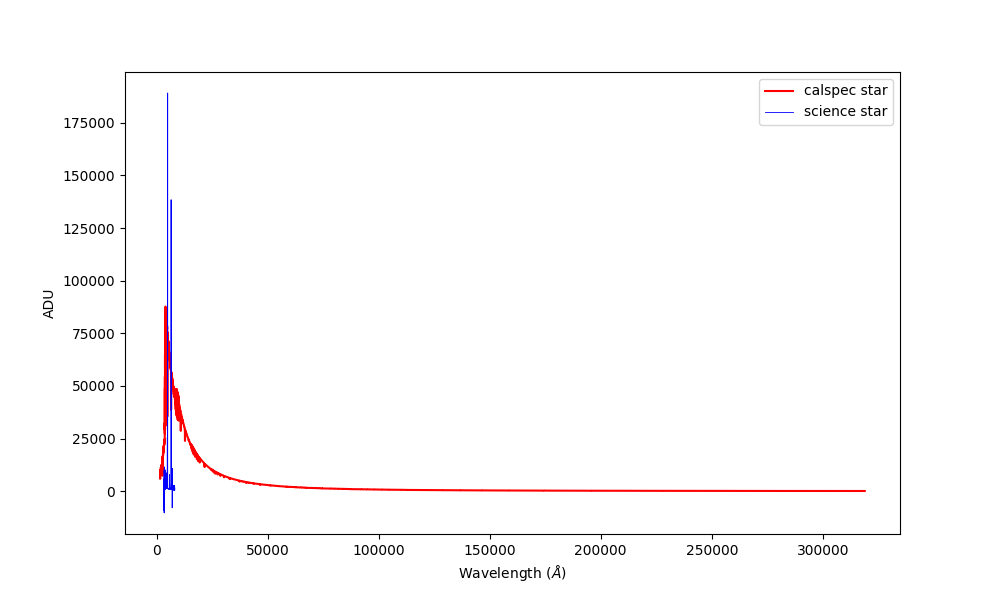

In [19]:
import matplotlib.pyplot as plt
from specreduce.calibration_data import load_MAST_calspec, load_onedstds
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import StdDevUncertainty
from specreduce.fluxcal import FluxCalibration
from specutils.manipulation import extract_region, gaussian_smooth, convolution_smooth, median_smooth
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.convolution import Box1DKernel
from astropy.modeling import models, fitting
from specutils.fitting import fit_generic_continuum
import astropy.wcs as fitswcs

#std_spec = load_onedstds(dataset = 'spec50cal', specfile = 'hd217086.dat')
#std_spec = load_onedstds(dataset = 'bstdscal', specfile = 'hr5511.dat')
std_spec = load_MAST_calspec("delumi_stis_004.fits")
#std_spec = load_MAST_calspec("bd60d1753_stiswfc_004.fits")

#std_slice = std_spec[3800*u.AA:8200*u.AA]
#sci_slice = sci_calibrated_spectrum[3800*u.AA:8200*u.AA]

std_slice = std_spec
sci_slice = sci_calibrated_spectrum


fig, ax = plt.subplots(figsize=(10,6))
ax.step(std_slice.spectral_axis, std_slice.flux, where="mid", label = 'calspec star')
ax.step(sci_slice.spectral_axis, sci_slice.flux, where="mid", label = 'science star')
ax.set_yscale('log')
ax.set_xlabel(f"Wavelength ({std_slice.spectral_axis.unit})")
ax.set_ylabel(f"Flux ({std_slice.flux.unit})");
plt.legend(loc=('best'))

obj_spectrum = Spectrum1D(spectral_axis = sci_slice.spectral_axis, flux = sci_slice.flux)
sci_spectrum = FluxCalibration(obj_spectrum, airmass = airmass) 

### reuse existing response file
if os.path.exists(dir + masterresponse):
    logger.info('reusing existing response file ... : ' + masterresponse)
    with fits.open(dir + masterresponse) as file:
        specdata = file[1].data
        header = file[1].header
        responsefunc = Spectrum1D(flux = specdata['flux'] * u.mJy, spectral_axis = specdata['wavelength'] * u.AA)
        final_spec = sci_spectrum.apply_sensfunc(responsefunc)
else:
    logger.info('creating a new response file ... : ' + masterresponse)
    responsefunc = sci_spectrum.standard_sensfunc(
        standard = std_slice,
        mode = 'linear',
        polydeg = 2,
        #badlines=[7516, 6563, 4861, 4341],
        display = False)
    final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    responsefunc.write(dir + masterresponse, overwrite = True)

final_spec.write(dir + 'final-1D-' + target + '.fit', overwrite = True)


plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(responsefunc.wavelength, responsefunc.flux, linewidth = '1.6', color = 'r');
plt.title('response curve')


plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.step(obj_spectrum.wavelength, obj_spectrum.flux, linewidth = '0.6', color = 'black');
plt.step(std_slice.spectral_axis, std_slice.flux, color = 'r', where="mid", label = 'calspec star')
plt.step(final_spec.wavelength, final_spec.flux, linewidth = '0.6', where="mid", color = 'b', label = 'science star');
plt.legend(loc=('best'))
#plt.step(std_spec.wavelength, std_spec.flux + 5000 * u.mJy, linewidth = '0.6', color = 'r')
#plt.xlim(3000, 9000)



## Analyse spectra

### Show known lines

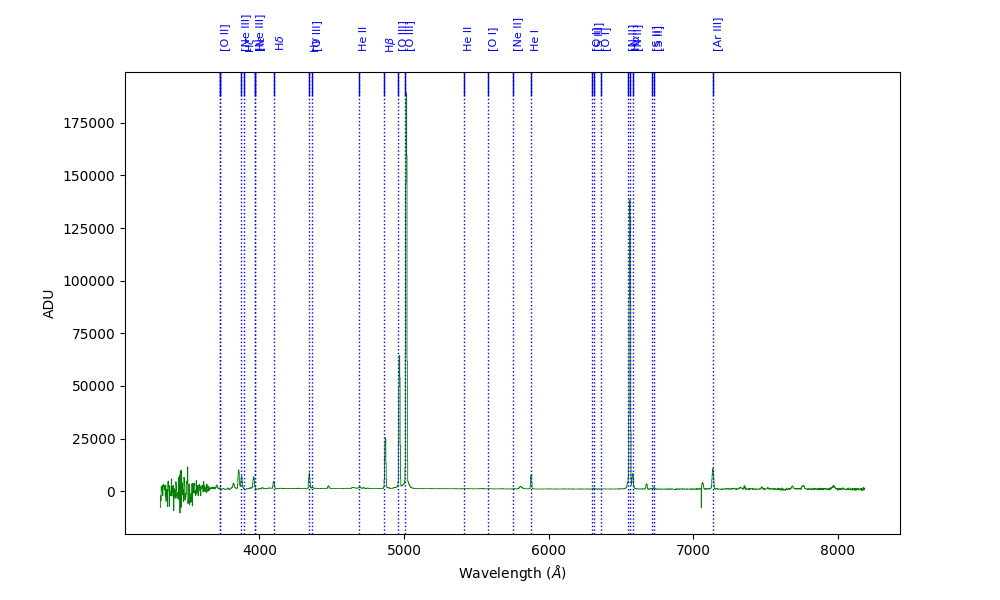

In [26]:
from spec_utils import show_lines
plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='green', linewidth = '0.6', where="mid")
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

show_lines(z = 0.0, ax = None, em_label = True, abs_label = False, rest_frame = True)


### Measure SNR

In [27]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils.analysis import snr, snr_derived
from specutils import Spectrum1D
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region

with fits.open(dir + 'final-1D-' + target + '.fit') as file:
    specdata = file[1].data
    header = file[1].header
    final_spec1d = Spectrum1D(flux = specdata['flux'] * u.mJy, spectral_axis = specdata['wavelength'] * u.AA)

print(f'snr = {snr_derived(final_spec1d)}')

snr = 17.74258073522422


### Remove continuum

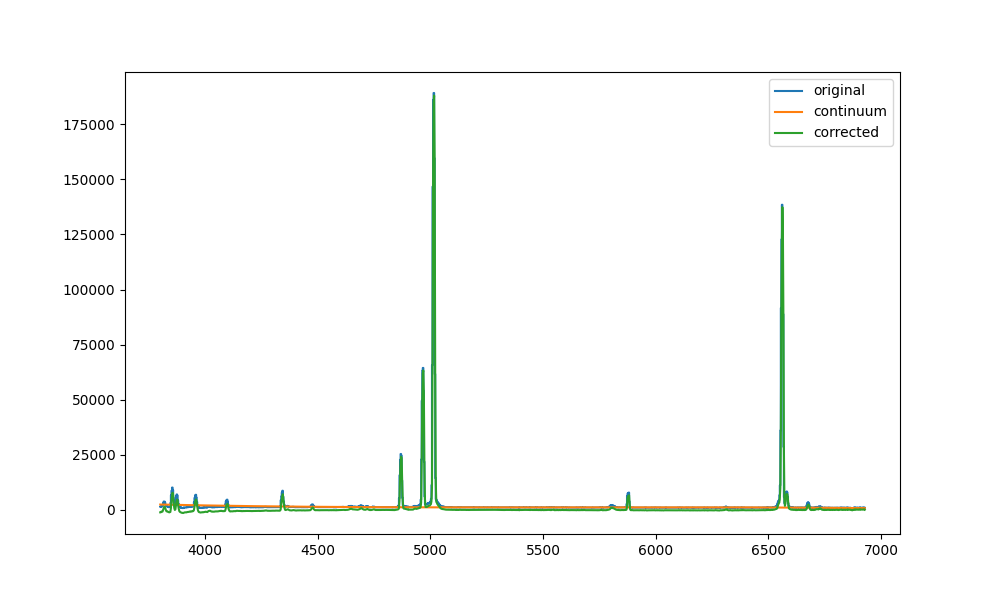

In [30]:
### extract continuum on a selected region

if True:
    region = SpectralRegion(3800*u.AA, 6930*u.AA)
    
    sub_spectra = extract_region(final_spec1d, region)
    
    generic_continuum = fit_generic_continuum(sub_spectra, exclude_regions = [
    #        SpectralRegion(3700 * u.AA, 4000 * u.AA),
    #         SpectralRegion(4825 * u.AA, 4885 * u.AA),
             SpectralRegion(4825 * u.AA, 5200 * u.AA),
             SpectralRegion(6400 * u.AA, 6800 * u.AA)
            ])
    #generic_continuum = fit_continuum(sub_spectra, models.Hermite1D(3))
    
    generic_continuum_evaluated = generic_continuum(sub_spectra.spectral_axis)
    
    spec_normalized = sub_spectra - generic_continuum_evaluated
    
    plt.figure(figsize = (10,6))
    plt.step(sub_spectra.spectral_axis, sub_spectra.flux)
    plt.plot(sub_spectra.spectral_axis, generic_continuum_evaluated)
    plt.plot(spec_normalized.spectral_axis, spec_normalized.flux)
    plt.legend(['original', 'continuum', 'corrected'], loc=('best'))
    #plt.xlim(4700, 5000)



### Identify lines

In [32]:
### identify lines
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

if True:
    lines = find_lines_derivative(spec_normalized, flux_threshold=500)
    print('emission: ', lines[lines['line_type'] == 'emission']) 
    print('absorption: ', lines[lines['line_type'] == 'absorption']) 


emission:     line_center     line_type line_center_index
     Angstrom                                 
------------------ --------- -----------------
3818.9379801038403  emission                 7
3856.3402061839406  emission                22
 3876.269321993756  emission                30
3958.3391385748937  emission                63
 4097.101572260548  emission               119
 4343.302967449819  emission               219
4477.8455701362645  emission               274
               ...       ...               ...
  4966.69706451234  emission               476
 5014.646044079713  emission               496
 5803.353144480106  emission               830
 5880.045941184162  emission               863
6562.5600885678505  emission              1161
 6580.633317820091  emission              1169
6677.5535954184925  emission              1212
 6726.995086568097  emission              1234
Length = 18 rows
absorption:     line_center     line_type  line_center_index
     Angstrom     

### Fit a line

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev      
           mJy              Angstrom          Angstrom     
    ------------------ ----------------- ------------------
    204192.44726099836 5015.942376184055 3.9824770408832784


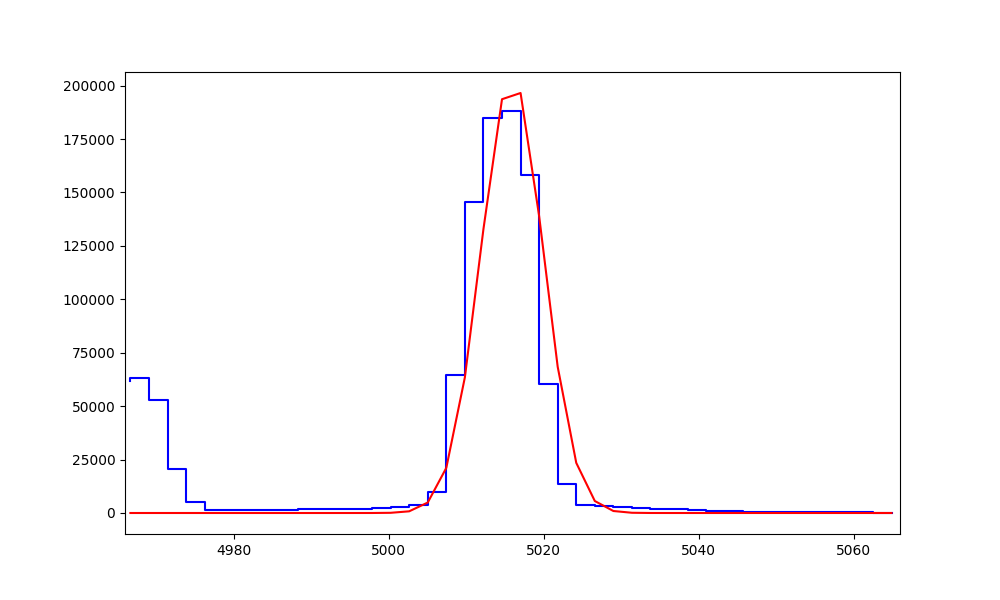

In [34]:
from specutils.manipulation import extract_region
from specutils.fitting import estimate_line_parameters
from specutils.analysis import centroid, fwhm
from specutils.fitting import fit_lines

if True:
    lineAA = 5016
    #lineAA = 6563
    sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)
    #sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)
    
    #create a new spectrum of the selected region for plot
    sub_spectrum = extract_region(spec_normalized, sr)
    Ha_line = Spectrum1D(flux = sub_spectrum.flux, spectral_axis = sub_spectrum.spectral_axis)
    
    line_estimate = models.Gaussian1D(mean = lineAA*u.AA, stddev = 5*u.AA, amplitude=20000)
    line_model = fit_lines(sub_spectrum, line_estimate)
    evaluated_model = line_model(sub_spectrum.wavelength)
    
    print(line_model)
    
    plt.figure(figsize = (10,6))
    #plt.step(reg_spectra.wavelength, reg_spectra.flux, label="Original spectrum")
    plt.step(Ha_line.spectral_axis, Ha_line.flux , label="original spectrum", color = 'b')
    plt.plot(Ha_line.spectral_axis, evaluated_model , label="Fit result", color = 'r')
    #plt.plot(Ha_line.spectral_axis, Ha_line.flux)
    plt.xlim(lineAA-50, lineAA+50)


### Measure line

In [36]:
### measure 
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi

if True:
    print(f'gaussian fwhm = {gaussian_fwhm(Ha_line)}' )
    center = centroid(spec_normalized, sr)  
    print(f'center = {center}')
    
    print(f'fwhm = {fwhm(Ha_line)}') 
    print(f'R = {(center / fwhm(Ha_line))}')
    print(f'fwzi = {fwzi(Ha_line)}') 
    
    print(f'line flux = {line_flux(Ha_line)}'  )
    
    #noisy_gaussian_with_continuum = noisy_gaussian + 1*u.Jy
    print(f'equivalent width = {equivalent_width(Ha_line)}')


gaussian fwhm = 44.741470715503375 Angstrom
center = 5007.084541406089 Angstrom
fwhm = 10.282520820570426 Angstrom
R = 486.95107248305277
fwzi = 25.0960904110118 Angstrom
line flux = 2573015.177076744 Angstrom mJy
equivalent width = -2572914.5740403254 Angstrom
